# Imports

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno # "pip install missingno"
from mpl_toolkits.mplot3d import Axes3D
import sklearn as sk
from importlib import reload
from datetime import datetime
from scipy.stats import multivariate_normal, norm

from IPython.display import display, Markdown, Latex

pd.options.display.max_rows = 25
np.set_printoptions(linewidth=1000, precision=3, suppress=True)

from hmmlearn import hmm # "pip install --upgrade --user hmmlearn"

import ucl_project_utilities as up 
reload(up)

import mppca # https://github.com/michelbl/MPPCA
reload(mppca)

print('Working directory:', os.getcwd())

H:\ucl_project_utilities.py @ 2021-09-19 14:47:46
H:\ucl_project_utilities.py @ 2021-09-19 14:47:46
Working directory: H:\


# Load and preprocess atm/skew data

In [2]:
reload(up)
print('Last run:', datetime.now())
df_all, expiries, tenors, strikes = up.load_and_preprocess(ccy='USD', files='old', skew_data=False)
df_all.head()

H:\ucl_project_utilities.py @ 2021-09-19 14:47:46
Last run: 2021-09-19 14:49:22.789111
Loading atm data...


C:\Users\imarcinko\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Loading time: 29.9 seconds
Prepping time: 4.7 seconds


,Date,Date Time (UTC),Date Time (Local),Ccy,Relative Strike,Expiry,Tenor,Expiry Num,Tenor Num,idx,...,Strike Price,Spot Premium OIS discounted,Normal Volatility IBOR discounted,Lognormal Volatility OIS discounted,Normal Volatility OIS discounted Calendar Days,Forward Premium,Lognormal Volatility IBOR discounted,Settlement,Standard Discounting,Vol
0,2006-03-01,2006-03-01 17:05:21.803000+00:00,2006-03-01 12:05:21.803000-05:00,USD,0,03M,02Y,0.25,2.0,31,...,5.111,48.3,65.0,NaN,NaN,0.0,12.7,NaN,NaN,64.898796
1,2006-03-01,2006-03-01 17:05:21.803000+00:00,2006-03-01 12:05:21.803000-05:00,USD,0,03M,10Y,0.25,10.0,39,...,5.112,205.6,67.0,NaN,NaN,0.0,13.1,NaN,NaN,66.955231
2,2006-03-01,2006-03-01 17:05:22.294000+00:00,2006-03-01 12:05:22.294000-05:00,USD,0,01Y,01Y,1.00,1.0,75,...,5.069,55.0,75.4,NaN,NaN,0.0,14.9,NaN,NaN,75.458291
3,2006-03-01,2006-03-01 17:05:22.218000+00:00,2006-03-01 12:05:22.218000-05:00,USD,0,01Y,05Y,1.00,5.0,79,...,5.081,269.7,81.5,NaN,NaN,0.0,16.0,NaN,NaN,81.209367
4,2006-03-01,2006-03-01 17:05:22.114000+00:00,2006-03-01 12:05:22.114000-05:00,USD,0,01Y,10Y,1.00,10.0,84,...,5.109,476.3,81.0,NaN,NaN,0.0,15.9,NaN,NaN,81.147612


# Data availability
* Atm data in general runs for most of the full period (2006-2021), but some expiries/tenors are denser than others
* Skew data is sparser, with a base period 2013-2021 and disparities across strikes
* We will focus on ATM as a first step

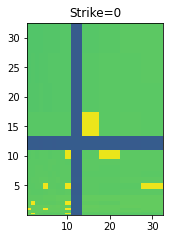

In [3]:
plt.figure(figsize=[20,12])
for k, K in enumerate(strikes,1):
    plt.subplot(3,7,k)
    z = up.data_density(df_all, K, expiries, tenors, cutoff=0, style='absolute')
    plt.pcolor(tenors, expiries, z, vmin=0, vmax=1, shading='auto')
    plt.title('Strike='+str(K))
    if k==11: 
        plt.colorbar()

**Upon closer inspection, it's clear that the early part of the series is not useful. They appear to start in earnest in:**
* Jun 2009 (2009-06-03) for "Normal Volatility IBOR discounted"
* Jan 2013 (2013-01-18) for "Normal Volatility OIS discounted Calendar Days"

* However "Lognormal Volatility IBOR discounted" seems to be reasonably clean. 
    * We transform it to normal vol using `lognormal_to_normal()` and use that for now.

<u><b>TODO</b></u>: review transform, get more explanations from ICAP on the missing data
* ICAP: "market used to be mainly lognormal vol-oriented, and this changed when rates became negative"

# Base PCA analysis

#### Data decisions

We impute missing data with scikit's iterative imputer for now. 

One possibility is to treat them as MAR and run EM for a probabilistic approach.

In any case we will run sensitivity analyses to understand the impact of any missing data adjustments we make.

**12Y expiries/tenors have high missingness, we remove them.**

* We also stop in Jan 2020 to limit data snooping
* And we take out some test data

In [4]:
START_DATE = '2006-01-01'
END_DATE = '2030-01-01' # i.e. all dates

MIN_EXPIRY = 0 # Higher number to keep only "Vega sector"

df_atm = df_all[(df_all['Relative Strike']==0) & df_all['Instrument'].str.contains('SOSWO') # SOSWO for atm instruments
                & (df_all['Date'] >= START_DATE) & (df_all['Date'] <= END_DATE) 
                & (df_all['Expiry'] != '12Y') & (df_all['Tenor'] != '12Y') # 12Y expiries/tenors date range 2016-21 only
                & (df_all['Expiry Num'] >= MIN_EXPIRY)
                & (df_all['Date'].dt.dayofweek < 5)] # Remove all Saturdays that are here for some reason

expiries = np.unique(df_atm['Expiry Num'])
tenors = np.unique(df_atm['Tenor Num'])

In [5]:
# Impute missing data (experimental!)
# TODO: we should actually treat this probabilistically when moving to PPCA
# TODO: we should explore just interpolating expiries/tenors instead (reduce temporal data snooping)
# TODO: also for missing data after start date, it would be ideal to only use prior data to impute
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.linear_model import Ridge
reload(up)
print('Last run:', datetime.now())

# Prepare data
atm_pt = pd.pivot_table(df_atm, values=['Vol'], index='Date', columns=['idx'])

atm_pt_tr_val = atm_pt.loc[:'2019-12-31']
atm_pt_te = atm_pt.loc['2020-01-01':]

#X0 = atm_pt_tr_val.values; MIN_IMP = 5
X0 = atm_pt.values; MIN_IMP = 5

# Remove outliers (prob a comment to make on data snooping on that!)
X0 = up.remove_outliers(X0,window=5,num_sd=4,obs_pct=0.1)

#X0_te = atm_pt_te.values
N0, D0 = X0.shape
N_val = 250
N_te = len(atm_pt_te)

# Split train/test data
N_TEMPORAL_HOLDOUT = 250
seed = None # TODO: analyse impact of randomness here
# TODO: think of a way to randomise even the TEMPORAL HOLDOUT, e.g. by having a max_period and drawing randomly from it
#idx_val = up.get_test_idx(X0.shape[0] - N_te, n_groups=int(0.05 * (X0.shape[0]-N_te)), group_size=2, seed=seed, force_n_last=N_TEMPORAL_HOLDOUT)

idx_train = np.arange(0,N0-N_te-N_val)
idx_val = np.arange(N0-N_te-N_val, N0-N_te) # We take only the last chronological part
idx_test = np.arange(N0-N_te,N0)
X0_tr = X0[idx_train,:]
X0_val = X0[idx_val,:]
X0_te = X0[idx_test,:]                          

idx_long_series = np.argsort(np.sum(np.isnan(X0_tr),0)) # For visualisation convenience later

# NOTE: the imputer below causes spikes in data which do 
# not make sense. We will run a first smoothing imputation
# for data missing in the middle of a series, then the imputer 
# only to impute the missing early years data (and the test data).
#for d in range(D0):
#    X0_tr[:,d] = up.interp_nan(X0_tr[:,d])    

# Impute
#imp_type = 'iterative'
#imp_type = 'knn'
imp_type ='gauss'

if imp_type == 'iterative':
    imp = IterativeImputer(max_iter=35, tol=1e-3, initial_strategy='mean', random_state=1, verbose=2, 
                           sample_posterior=False, n_nearest_features=None, min_value = MIN_IMP) # TODO: review (not converging)
    is_imp = True
elif imp_type == 'knn':
    imp = KNNImputer(n_neighbors=7, weights='distance') # Better ?
    is_imp = True
elif imp_type == 'gauss':
    imp = up.GaussImputer(sample=True)
    is_imp = True

if is_imp:
    X1_tr = imp.iterate(X0_tr, n_iter=50, verbose=True, rel_tol=0.0025)
    # X1_tr = imp.fit_transform(X0_tr) # TODO: think about data snooping (look-ahead bias) impact here
    X1_val = imp.transform(X0_val)
    X1_te = imp.transform(X0_te)
    X1 = imp.transform(X0)

H:\ucl_project_utilities.py @ 2021-09-19 14:47:46
Last run: 2021-09-19 14:50:00.924446
Gaussian imputer iteration 0 (dmean=nan,dcov=nan)
Gaussian imputer iteration 1 (dmean=0.02,dcov=0.016)
Gaussian imputer iteration 2 (dmean=0.012,dcov=0.009)
Gaussian imputer iteration 3 (dmean=0.01,dcov=0.007)
Gaussian imputer iteration 4 (dmean=0.006,dcov=0.006)
Gaussian imputer iteration 5 (dmean=0.007,dcov=0.004)
Gaussian imputer iteration 6 (dmean=0.007,dcov=0.006)
Gaussian imputer iteration 7 (dmean=0.007,dcov=0.004)
Gaussian imputer iteration 8 (dmean=0.006,dcov=0.004)
Gaussian imputer iteration 9 (dmean=0.004,dcov=0.003)
Gaussian imputer iteration 10 (dmean=0.005,dcov=0.003)
Gaussian imputer iteration 11 (dmean=0.004,dcov=0.004)
Gaussian imputer iteration 12 (dmean=0.005,dcov=0.004)
Gaussian imputer iteration 13 (dmean=0.003,dcov=0.001)
Gaussian imputer iteration 14 (dmean=0.004,dcov=0.003)
Gaussian imputer iteration 15 (dmean=0.004,dcov=0.002)
Gaussian imputer iteration 16 (dmean=0.003,dcov=0

#### Visualisation of the first few Principal Components

* In general across the 4 datasets (USD-EUR-JPY-GBP), the first 5 PCs explain ~95%+ of the variance

H:\ucl_project_utilities.py @ 2021-09-19 14:47:46


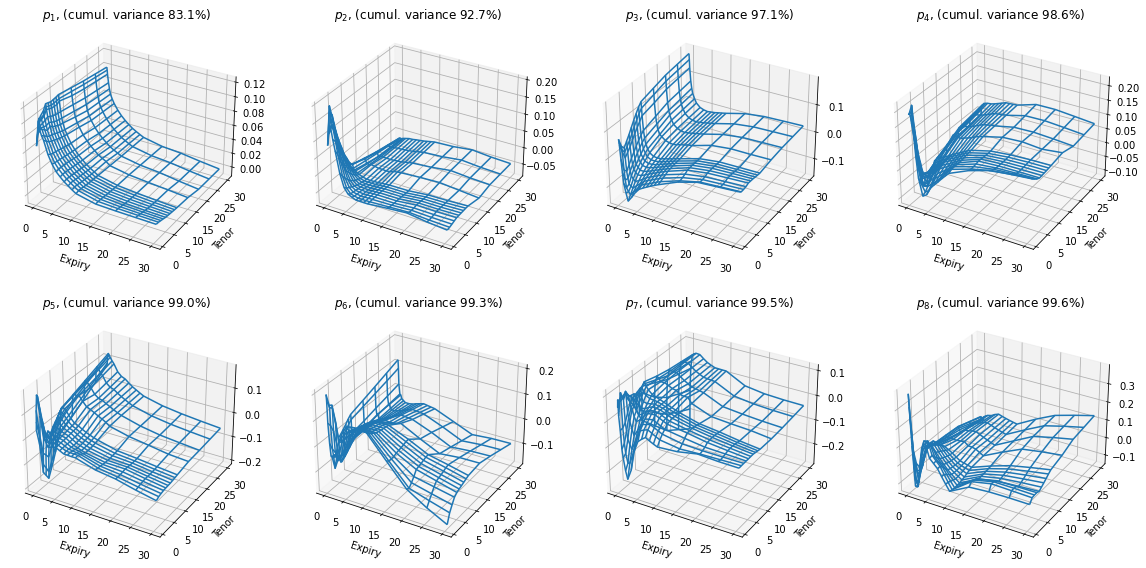

In [9]:
reload(up)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

N, D = X1_tr.shape

scaler = StandardScaler(with_mean=True, with_std=False) # TODO: analyse/discuss/decide covariance vs. correlation
#scaler = up.DynamicCenterer()
#X_tr = X1_tr - np.cumsum(X1_tr,axis=0)/np.arange(1,N+1).reshape(-1,1) #scaler.fit_transform(X_tr)
X_tr = scaler.fit_transform(X1_tr)
X_val = scaler.transform(X1_val)
X_te = scaler.transform(X1_te)
X_all = scaler.transform(X1)
X = scaler.transform(X1) # alias

Q = D ### 

pca = PCA(n_components=Q, svd_solver='full')
pca.fit(X_tr)

pcs = np.full((Q,D),np.nan)
pcs[:,:] = pca.components_
pca.pcs_ = pcs

expiries = np.unique(df_atm['Expiry Num'])
tenors = np.unique(df_atm['Tenor Num'])

DISPLAY_Q = 8
#up.display_pcs(pca, expiries, tenors, M=DISPLAY_Q, zlim=[np.min(pcs)-0.01,np.max(pcs)+0.01], show_variance=False)
up.display_pcs(pca, expiries, tenors, M=DISPLAY_Q, zlim=None, show_variance=False)

### Boostrap the PPCA fit to understand variance of variance curves

In [10]:
#B = 5000 # as per paper but a bit long to run
B = 100
var_curve = np.full((B,D),np.nan)
pca_b = PCA(n_components=D, svd_solver='full')

np.random.seed(0)
for b in range(B):
    idx = np.random.choice(N,size=N,replace=True)
    X_b = X_tr[idx]
    pca_b.fit(X_b)
    var_curve[b] = np.cumsum(pca_b.explained_variance_ratio_  )

#cum_vc = np.cumsum(var_curve.T,axis=0)
cum_vc = var_curve.T
for i in range(10):    
    pct = np.percentile(cum_vc[i],[1,99])
    print(np.array([pct[0], np.cumsum(pca.explained_variance_ratio_)[i], pct[1]]))
    #print(np.array([pct[0], (pca.explained_variance_ratio_)[i], pct[1]]))


[0.821 0.831 0.842]
[0.923 0.927 0.931]
[0.97  0.971 0.973]
[0.985 0.986 0.987]
[0.99  0.99  0.991]
[0.992 0.993 0.993]
[0.994 0.995 0.995]
[0.995 0.996 0.996]
[0.996 0.996 0.997]
[0.997 0.997 0.997]


In [11]:
y1 = np.min(var_curve.T,1) - np.cumsum(pca.explained_variance_ratio_)
y2 = np.max(var_curve.T,1) - np.cumsum(pca.explained_variance_ratio_)
yerr = np.vstack([-y1.reshape(1,-1),y2.reshape(1,-1)])[:,:DISPLAY_Q]

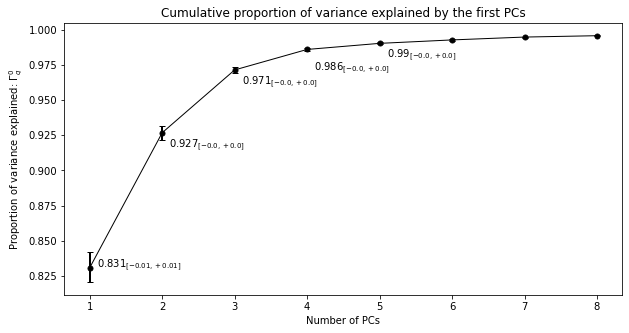

In [12]:

plt.figure(figsize=[10,5])
#_ = plt.plot(range(1,DISPLAY_Q+1),np.cumsum(pca.explained_variance_ratio_[:DISPLAY_Q]),'o-k')
_ = plt.errorbar(range(1,DISPLAY_Q+1),np.cumsum(pca.explained_variance_ratio_[:DISPLAY_Q]),
                 yerr=yerr,c='k',fmt='o-',
                 markersize=5,linewidth=1,elinewidth=2,capsize=3)
#_ = plt.bar(range(1,DISPLAY_Q+1),np.cumsum(pca.explained_variance_ratio_[:DISPLAY_Q]))
_ = plt.xticks(ticks=range(1,DISPLAY_Q+1))
plt.title(r'Cumulative proportion of variance explained by the first PCs')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of variance explained: $\Gamma_{q}^0$')
dy = [0,-0.01,-0.01,-0.015,-0.01]
for i, q in enumerate([0,1,2,3,4]):
    ylo = np.round(yerr[0,i],2)
    yhi = np.round(yerr[1,i],2)
    
    plt.text(q+1+0.1,dy[i]+np.cumsum(pca.explained_variance_ratio_[:DISPLAY_Q])[q],             
             str(np.round(np.cumsum(pca.explained_variance_ratio_[:DISPLAY_Q])[q],3))+r'$_{['+'-{},+{}'.format(ylo,yhi)+r']}$')

#### Visualisation in 2D

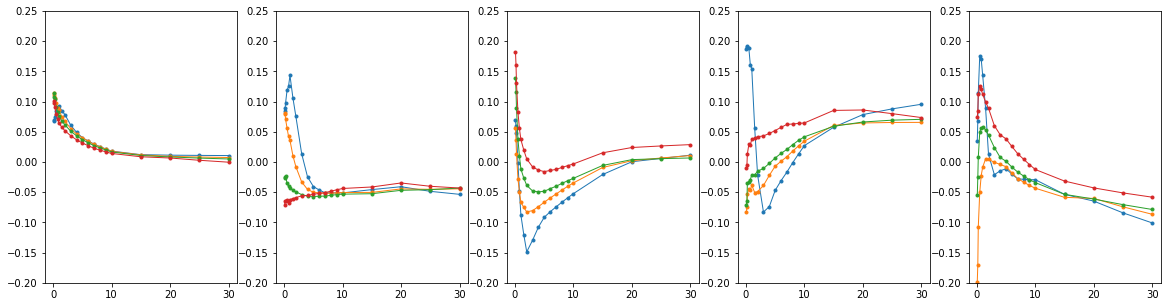

In [13]:
Q_max = 5
plt.figure(figsize=[20,5])
#display_t = tenors
display_t = [1,5,10,30]
idx_t = [tenors.tolist().index(t) for t in display_t]
exp0 = 0 # only show after this expiry (clearer for understanding)
for q in range(Q_max):
    plt.subplot(1,Q_max,q+1)
    pc_2d = pca.components_[q].reshape((len(expiries),len(tenors))) * np.sign(pca.components_[q,0])
    
    _ = plt.plot(expiries[exp0:], pc_2d[exp0:,idx_t],'.-', linewidth=1)
    plt.ylim([-0.2,0.25])
    

### Influence of each factor on individual swaptions

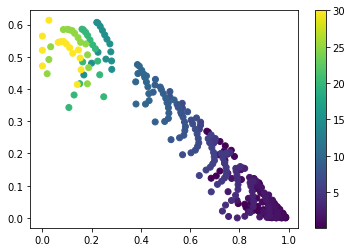

In [14]:
l1 = pca.singular_values_[0]**2
l2 = pca.singular_values_[1]**2
v1 = pca.components_[0]**2*l1
v2 = pca.components_[1]**2*l2
vall = pca.components_.T**2 @ pca.singular_values_**2

x_exp, y_ten = np.meshgrid(expiries, tenors)

plt.scatter(v1/vall,v2/vall,c=x_exp.T.flatten())
#plt.scatter(v1/vall,v2/vall,c=y_ten.T.flatten(),s=3)
plt.colorbar()

H:\ucl_project_utilities.py @ 2021-09-19 14:47:46


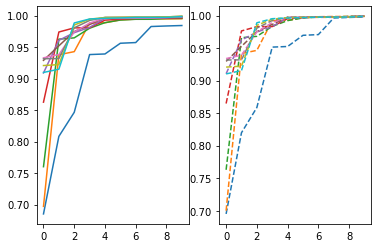

In [15]:
reload(up)
ppca = up.PPCA(X_tr,fit=True)
Z = ppca.ZQ(Q=10, normalise=True)
#Zp = ppca.ZQ(Q=10, normalise=True, projection='ppca')

Q = 10
N_SHOW = 10
# print(Z.T @ Z / N)
# print(Zp.T @ Zp / N)

# Explained variance PCA
plt.subplot(1,2,1)
exp_var = ppca.rvar[:N_SHOW].T.cumsum(axis=0)[:Q]
plt.plot(exp_var)

# Explained variance PPCA
# (explained as % of model variance)
W = ppca.W(Q=Q)
s2 = ppca.s2(Q=Q)
m_cov = W @ W.T + s2 * np.eye(D)
m_var = np.diag(m_cov)
m_exp_var = W**2 / m_var.reshape(-1,1)
m_exp_var = m_exp_var[:N_SHOW].cumsum(axis=1).T
plt.subplot(1,2,2)
_ = plt.plot(m_exp_var,'--')


# Display all PPCA results in a one-pager graphical format

H:\ucl_project_utilities.py @ 2021-09-19 21:39:53
3.5466557895881654
3.5466557895881654


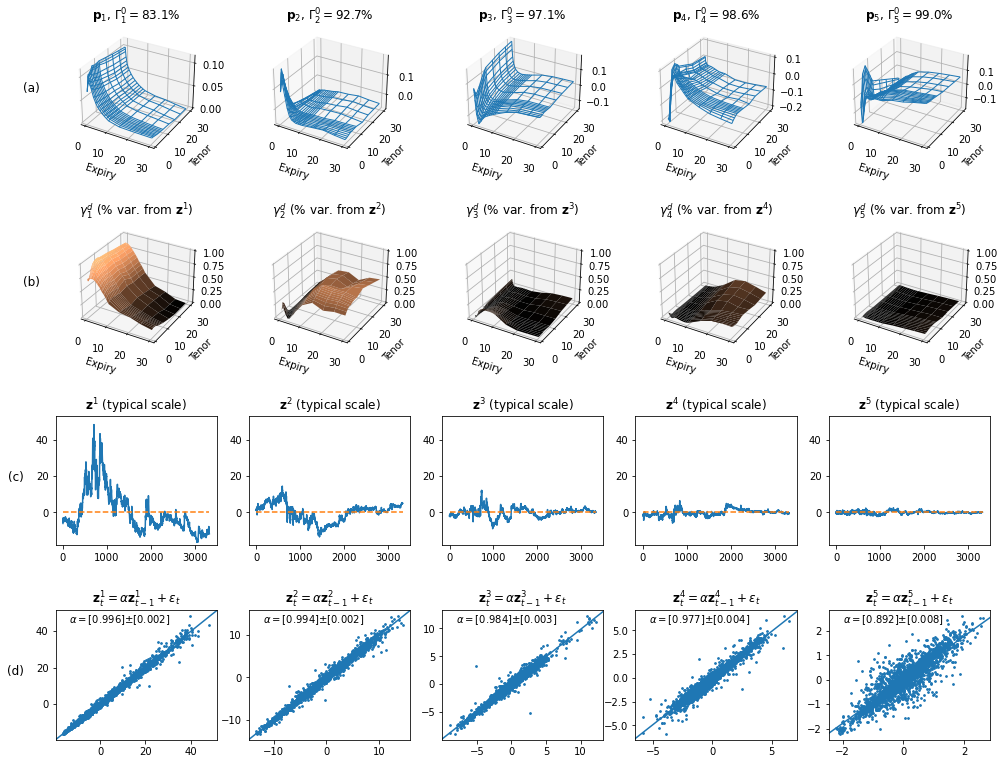

In [365]:
# Putting it all together in one big chart
reload(up)

N_ROWS = 4
fig = plt.figure(figsize = [15,3*N_ROWS])
#fig.suptitle('PPCA model: results',fontsize=20)

n_exp = len(expiries)
n_ten = len(tenors)
X, Y = np.meshgrid(expiries, tenors)

ppca = up.PPCA(X_tr,fit=True)
P_surf = ppca.P_surf(n_exp,n_ten)

rf = up.ResidualsFitter(fit_intercept=True)

def annotate_ax(ax, txt):
    ax.annotate(txt, xy=(0, 0.5), xytext=(-40, 0), 
                xycoords='axes fraction', textcoords='offset points', size='large', ha='center', va='baseline')
    

Q = 5
projection = 'ppca'
ZQ = ppca.ZQ(Q=Q, normalise=False, projection=projection)
for q in range(Q):
    # Principal components
    ax = plt.subplot(N_ROWS,Q,q+1,projection='3d')
    ax.plot_wireframe(X,Y,P_surf[q].T,linewidth=1)
    #ax.plot_surface(X,Y,P_surf[q].T,cmap='cool',vmin=np.min(ppca.P[:,:Q]),vmax=np.max(ppca.P[:,:Q]))
    ax.set_xlabel('Expiry')
    ax.set_ylabel('Tenor')
    #ax.set_zlabel('Loadings')
    exp_var_r = np.round(100*ppca.pca.explained_variance_ratio_.cumsum()[q],1)
    ax.set_title(r'$\mathbf{p}_'+'{}$'.format(q+1)+', $\Gamma_{'+str(q+1)+'}^0=$'+str(exp_var_r)+'%')    
    if q==0: annotate_ax(ax, '(a)')
    
    # % of variance from each factor, for all series
    ax = plt.subplot(N_ROWS,Q,1*Q+q+1,projection='3d')
    ax.plot_surface(X,Y,ppca.rvar[:,q].reshape(n_exp, n_ten).T,vmin=0,vmax=1,cmap='copper')
    ax.set_xlabel('Expiry')
    ax.set_ylabel('Tenor')
    ax.set_zlim([0,1])    
    ax.set_title(r'$\gamma^d_{'+str(q+1)+'}$ for all series')    
    ax.set_title(r'$\gamma^d_{'+str(q+1)+'}$ (% var. from $\mathbf{z}^{'+str(q+1)+'}$)')    
    if q==0: annotate_ax(ax, '(b)')
        
    # Z time series adjusted by typical scale (defined as median abs loading)    
    ax = plt.subplot(N_ROWS,Q,2*Q+q+1)
    m = np.median(np.abs(ppca.P[:,:Q]),axis=0)        
    ax.plot(ZQ[:,q]*m[q])    
    ax.plot([0,N],[0,0],'--')
    ax.set_ylim([np.min(ZQ*m)*1.1,np.max(ZQ*m)*1.1])
    ax.set_title(r'$\mathbf{z}^{'+str(q+1)+'}$ (typical scale)')    
    if q==0: annotate_ax(ax, '(c)')
        
    # Factor AR(1) regression
    ax = plt.subplot(N_ROWS,Q,3*Q+q+1)
    rf.fit(ZQ[:,q])
    x, y = ZQ[:-1,q] * m[q], ZQ[1:,q] * m[q]
    ax.scatter(x,y,s=3)
    hi = np.maximum(x,y).max()
    lo = np.minimum(x,y).min()
    dl = 0.05*(hi-lo)
    ax.set_xlim([lo-dl,hi+dl])
    ax.set_ylim([lo-dl,hi+dl])
    plt.plot([lo-dl,hi+dl],[lo-dl,hi+dl]*rf.alpha_)
    ax.set_title(r'$\mathbf{z}^{'+str(q+1)+r'}_t = \alpha\mathbf{z}^{'+str(q+1)+r'}_{t-1}+\epsilon_t$')    
    ax.annotate(r'$\alpha=$'+str(rf.alpha_)+r'$\pm$'+str(rf.alpha_se_), xy=(0.4, 0.9), xytext=(0, 0), 
                xycoords='axes fraction', textcoords='offset points', size='large', ha='center', va='baseline', fontsize=10)
    if q==0: annotate_ax(ax, '(d)')

    
    
plt.subplots_adjust(top=0.95, right=0.99, hspace=0.5)
plt.savefig(r'H:\report-img\ppca-res.png', bbox_inches='tight', pad_inches=0)



# MR in the factors

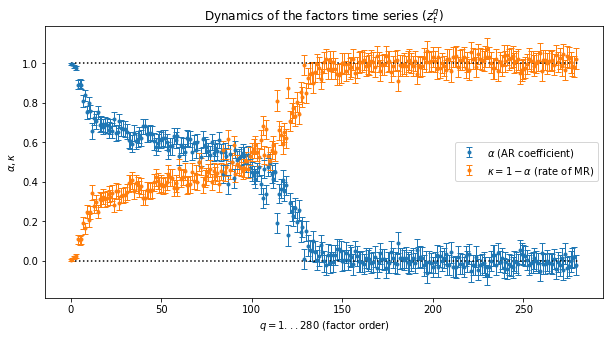

In [366]:
plt.figure(figsize=[10,5])
N_STD = 3

Z_all = ppca.ZQ(Q=D, projection='pca')
zf = up.ResidualsFitter(fit_intercept=True)
zf.fit(Z_all)

plt.errorbar(np.arange(D), zf.alpha_, yerr=N_STD*zf.alpha_se_, fmt='.', capsize=3, linewidth=1, label=r'$\alpha$ (AR coefficient)')
plt.errorbar(np.arange(D), 1-zf.alpha_, yerr=N_STD*zf.alpha_se_, fmt='.', capsize=3, linewidth=1, label=r'$\kappa = 1 - \alpha$ (rate of MR)')
plt.plot([0,D],[0,0],':k')
plt.plot([0,D],[1,1],':k')
plt.title('Dynamics of the factors time series ($z_t^q$)')
plt.ylabel(r'$\alpha, \kappa$')
plt.xlabel('$q=1...280$ (factor order)')
plt.legend()



H:\ucl_project_utilities.py @ 2021-09-19 22:18:55


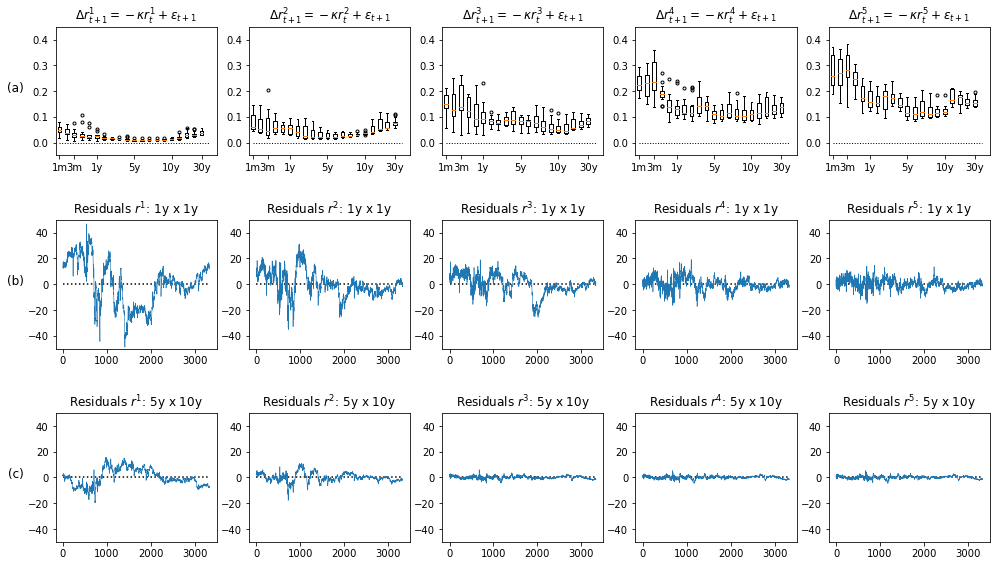

In [368]:
# Putting it all together in one big chart
reload(up)

N_ROWS = 3
fig = plt.figure(figsize = [15,3*N_ROWS])
#fig.suptitle('PPCA model: results',fontsize=20)

n_exp = len(expiries)
n_ten = len(tenors)
X, Y = np.meshgrid(expiries, tenors)

ppca = up.PPCA(X_tr,fit=True)
P_surf = ppca.P_surf(n_exp,n_ten)

rf = up.ResidualsFitter(fit_intercept=True)

def annotate_ax(ax, txt):
    ax.annotate(txt, xy=(0, 0.5), xytext=(-40, 0), 
                xycoords='axes fraction', textcoords='offset points', size='large', ha='center', va='baseline')
    

Q = 5
projection = 'ppca'
ZQ = ppca.ZQ(Q=Q, normalise=False, projection=projection)
for q in range(Q):

    
    # Sample residuals ts
    ax = plt.subplot(N_ROWS,Q,Q+q+1) 
    exp = 1
    ten = 1
    idx = up.ext_to_idx(exp,ten,expiries.tolist(),tenors.tolist()) # Illustrate series 5yx10y
    RQ = ppca.RQ(Q=q+1,projection=projection)[:,idx]
    ax.plot(RQ,linewidth=0.6)
    ax.plot([0,N],[0,0],':k',zorder=0)
    ax.set_ylim([-50,50])    
    #plt.title(str(exp)+'y x '+str(ten)+'y residuals: $\mathbf{v}_t-\mathbf{W}\mathbf{z}_{1:'+str(q+1)+'}$')
    plt.title('Residuals $r^{}$: '.format(q+1)+str(exp)+'y x '+str(ten)+'y')
    if q==0: annotate_ax(ax, '(b)')
        
    # Sample residuals ts 2
    ax = plt.subplot(N_ROWS,Q,2*Q+q+1) 
    exp = 5
    ten = 10
    idx = up.ext_to_idx(exp,ten,expiries.tolist(),tenors.tolist()) # Illustrate series 5yx10y
    RQ = ppca.RQ(Q=q+1,projection=projection)[:,idx]
    ax.plot(RQ,linewidth=0.6)
    ax.plot([0,N],[0,0],':k',zorder=0)
    ax.set_ylim([-50,50])    
    #plt.title(str(exp)+'y x '+str(ten)+'y residuals: $\mathbf{v}_t-\mathbf{W}\mathbf{z}_{1:'+str(q+1)+'}$')
    plt.title('Residuals $r^{}$: '.format(q+1)+str(exp)+'y x '+str(ten)+'y')
    if q==0: annotate_ax(ax, '(c)')
    
    # mean-reversion of residuals
    ax = plt.subplot(N_ROWS,Q,q+1)
    rf.fit(ppca.RQ(Q=q+1,projection=projection))
    #ax.plot_surface(X,Y,1-rf.alpha_.reshape(n_exp, n_ten).T,vmin=0,vmax=0.4,cmap='copper')
    #ax.set_zlim([0,0.4])
    up.make_boxplot(1-rf.alpha_.reshape(n_exp, n_ten).T,expiries,ylim=[-0.05,0.45],hline=0)
    plt.title(r'$\Delta r_{t+1}^'+str(q+1)+r' = -\kappa r_t^'+str(q+1)+r'+ \epsilon_{t+1}$')   
    if q==0: annotate_ax(ax, '(a)')
    
    
plt.subplots_adjust(top=0.92, right=0.99, hspace=0.5)
#plt.savefig(r'H:\report-img\ppca-residuals.png', bbox_inches='tight', pad_inches=0)



## Validation data

H:\ucl_project_utilities.py @ 2021-09-19 22:18:55
1615.5906370424434 2.2709
2651.5260012280564 3.0598
3214.2662594991707 3.9866
3962.4003454084195 4.3565
4380.790255840372 3.9269


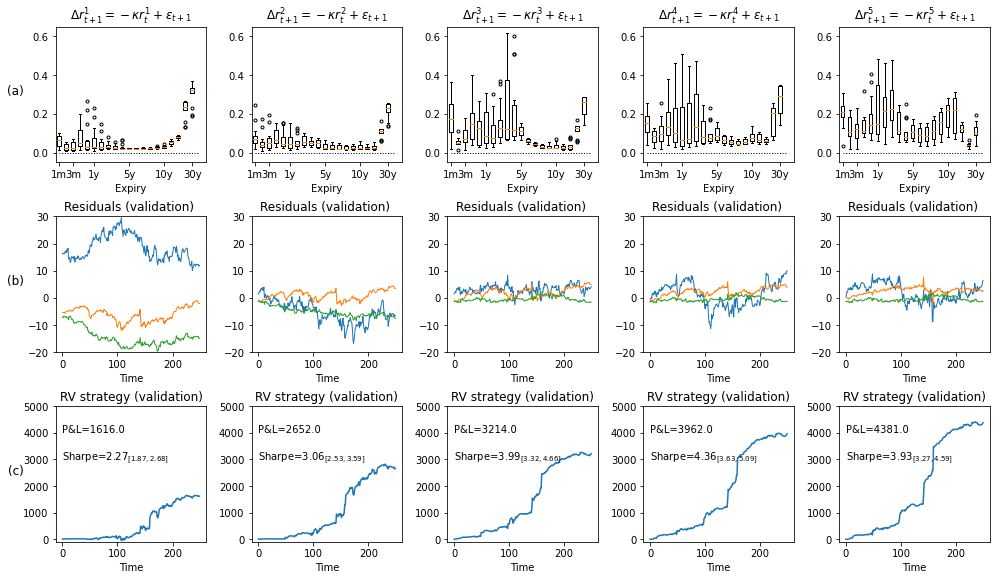

In [370]:
reload(up)

N_ROWS = 3
fig = plt.figure(figsize = [15,3*N_ROWS])
#fig.suptitle('PPCA model: results',fontsize=20)

ppca_val = up.PPCA(X_val,copy=ppca)
ppca_val.mu = ppca.mu # Should be the same as learned on training data
rf_val = up.ResidualsFitter(fit_intercept=True) # We refit for illustration, but not for strategy calc !

projection = 'ppca'

for q in range(Q):
    # Kappa on the fitted validation data (just for info)
    ax = plt.subplot(N_ROWS,Q,q+1)
    RQ = ppca_val.RQ(Q=q+1, projection=projection)
    rf_val.fit(RQ)        
    up.make_boxplot(1-rf_val.alpha_.reshape(n_exp, n_ten).T,expiries,ylim=[-0.05,0.65],hline=0)    
    ax.set_title(r'$\Delta r_{t+1}^'+str(q+1)+r' = -\kappa r_t^'+str(q+1)+r'+ \epsilon_{t+1}$')   
    ax.set_xlabel('Expiry')
    if q==0: annotate_ax(ax, '(a)')
    
    # Residuals plots for a few series...
    ax = plt.subplot(N_ROWS,Q,1*Q+q+1)
    ax.plot(RQ[:,idx_long_series[:3]], linewidth=1)    
    if q==0: annotate_ax(ax, '(b)')
    plt.title('Residuals (validation) ')
    plt.ylim([-20,30])
    ax.set_xlabel('Time')
    
    # Check strat (on the training, not validation, MR fit!)
    rf.fit(ppca.RQ(Q=q+1,projection=projection))
    thr_sr = 3
    cum_pnl_val = np.nansum(rf.trading_stategy(RQ,m=thr_sr/np.sqrt(252))[2],axis=1).cumsum()
    ax = plt.subplot(N_ROWS,Q,2*Q+q+1)
    ax.plot(cum_pnl_val)
    plt.ylim([-100,5000])
    print(cum_pnl_val[-1], up.Sharpe(cum_pnl_val))
    ax.text(0,4000,'P&L='+str(np.round(cum_pnl_val[-1],0)))
    sr,sr_lo,sr_hi = up.Sharpe(cum_pnl_val,return_ci=True,round_sr=2)
    ax.text(0,3000,'Sharpe='+str(sr)+r'$_{['+str(sr_lo)+','+str(sr_hi)+']}$')
                              
    if q==0: annotate_ax(ax, '(c)')
    plt.title('RV strategy (validation)')
    ax.set_xlabel('Time')
        

plt.subplots_adjust(top=0.92, right=0.99, hspace=0.4, wspace=0.3)


# We choose Q = 4 which has the highest Sharpe and second highest return

## And now check performance on the holdout test set after refitting on train+val data

H:\ucl_project_utilities.py @ 2021-09-19 22:18:55
5365.643279938424 3.6278


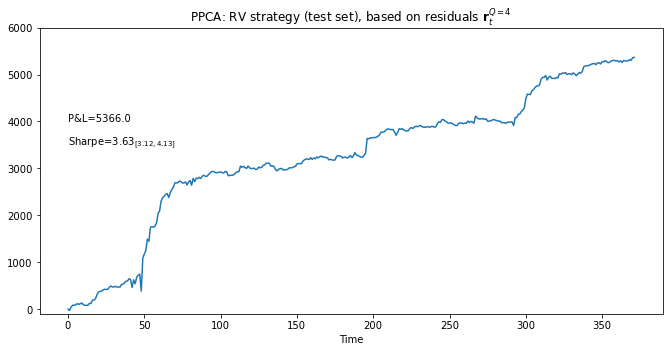

In [487]:
# Perf on test set
reload(up)
from scipy.stats import norm

fig = plt.figure(figsize = [10,5])
#fig.suptitle('PPCA model: results',fontsize=20)

X1_tr_val = np.vstack([X1_tr,X1_val])
scaler_tr_val = StandardScaler(with_mean=True, with_std=False)
X_tr_val = scaler_tr_val.fit_transform(X1_tr_val)

ppca_refit = up.PPCA(X_tr_val,fit=True)

ppca_te = up.PPCA(X_te,copy=ppca)
ppca_te.mu = ppca.mu # Should be the same as learned on training data

projection = 'ppca'

q_opt = 4    
# Check strat (on the training, not test, MR fit!)
RQ = ppca_te.RQ(Q=q_opt, projection=projection)
rf.fit(ppca_refit.RQ(Q=q_opt,projection=projection))
cum_pnl_te = np.nansum(rf.trading_stategy(RQ,m=3/np.sqrt(252))[2],axis=1).cumsum()
ax = plt.subplot(1,1,1)
ax.plot(cum_pnl_te)
plt.ylim([-100,6000])
sr, sr_lo, sr_hi = up.Sharpe(cum_pnl_te,return_ci=True,round_sr=2)
level = 0.01
print(cum_pnl_te[-1], up.Sharpe(cum_pnl_te))
ax.text(0,4000,'P&L='+str(np.round(cum_pnl_te[-1],0)))
ax.text(0,3500,'Sharpe='+str(np.round(up.Sharpe(cum_pnl_te),2))+r'$_{['+str(sr_lo)+','+str(sr_hi)+']}$')

if q==0: annotate_ax(ax, '(c)')
plt.title('PPCA: RV strategy (test set), based on residuals $\mathbf{r}_t^{Q=4}$')
ax.set_xlabel('Time')


plt.subplots_adjust(top=0.92, right=0.99, hspace=0.4, wspace=0.3)


H:\ucl_project_utilities.py @ 2021-09-19 22:18:55


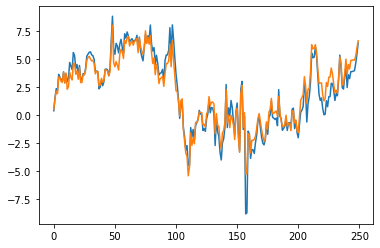

In [443]:
reload(up)
RQ = ppca_val.RQ(Q=q+1,projection='ppca')
#pos_val = rf.trading_stategy(RQ,m=3/np.sqrt(252))[3]
plt.plot(RQ[:,idx_long_series[0]])
RQ = ppca_val.RQ(Q=q+1,projection='pca')
plt.plot(RQ[:,idx_long_series[0]])
#plt.plot(pos_val[:,idx_long_series[0]]*10)

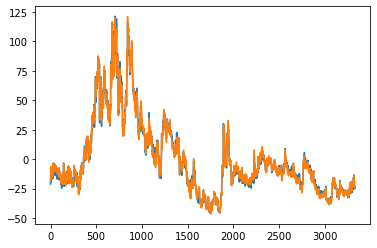

In [373]:
# PP.T is the matrix of tracking baskets: each column (d) is the basket tracking asset (d)
QQ = 5
B = ppca.P[:,:QQ] @ ppca.P[:,:QQ].T
k = idx_long_series[-1]
plt.plot(X_tr[:,k])
plt.plot(X_tr @ B[:,k])



### Display all MPPCA results

In [353]:
# Fit the MPPCA using multiple starts
reload(up)
N_STARTS = 10
N_GMM_STARTS = 4
M = 2 # Mixtures
Q = 10 # Latent space dimension

#plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, N_STARTS+3))))

idx_max = 0
llh_max = -np.inf
mppca_list = []
for s in range(N_STARTS):
    model = up.MPPCA(M=M, Q=Q, initialisation='gmm' if s < N_GMM_STARTS else 'random', max_iter=250, tol=1e-4)
    mppca_list.append(model)
    model.fit(X_tr)
    if np.nanmax(model.L_) > llh_max:
        mppca = model
        llh_max = np.nanmax(model.L_)
    llh_list = np.array([m.L_.tolist() for m in mppca_list]).T    
    
print(N_STARTS, 'starts completed!')


H:\ucl_project_utilities.py @ 2021-09-19 21:39:53
MPPCA iteration:0 25 
MPPCA iteration:0 25 
MPPCA iteration:0 25 
MPPCA iteration:0 
MPPCA iteration:0 25 50 
MPPCA iteration:0 25 50 
MPPCA iteration:0 25 50 75 
MPPCA iteration:0 25 
MPPCA iteration:0 25 
MPPCA iteration:0 25 
10 starts completed!


## Illustrate the fit for MPPCA

Text(0.5, 0, 'Observation')

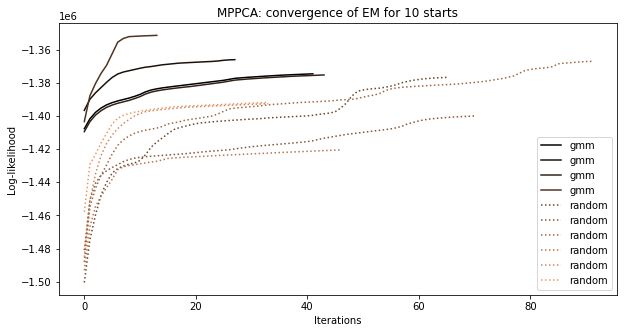

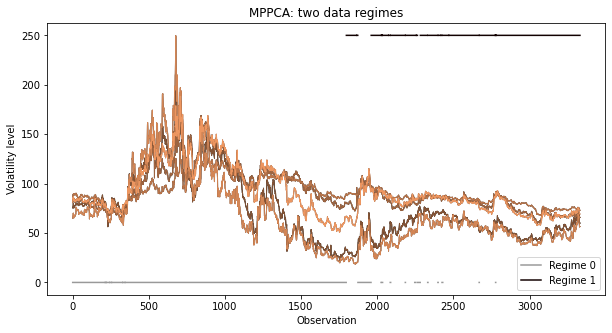

In [354]:
# Convergence of EM
plt.figure(figsize=[10,5])
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, N_STARTS+3))))
[plt.plot(model.L_[2:],'-' if model.initialisation=='gmm' else ':', label=model.initialisation) for model in mppca_list]
plt.legend()
plt.title('MPPCA: convergence of EM for 10 starts')
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')

# Identified periods
plt.figure(figsize=[10,5])
idx_mix = mppca.predict(X_tr,output='m')
X1_mix = np.full((mppca.M, X1_tr.shape[0], X1_tr.shape[1]),np.nan)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, N_STARTS+3))))
for m in range(mppca.M):    
    idx = (idx_mix==m)
    X1_mix[m][idx] = X1_tr[idx]
    #plt.plot(X1_mix[m][:,idx_long_series[:5]],'k' if m==0 else 'r', linewidth=1,label='Population'+str(m))
    plt.plot(X1_tr[:,idx_long_series[:5]],linewidth=1)


idx_0 = idx_mix * np.nan
idx_0[idx_mix==0] = 0
idx_1 = idx_mix * np.nan
idx_1[idx_mix==1] = 1
plt.plot(idx_0*250,c='#999999',label='Regime 0')
plt.plot(idx_1*250,c='#110000', label='Regime 1')
plt.legend()
plt.title('MPPCA: two data regimes')
plt.ylabel('Volatility level')
plt.xlabel('Observation')



    


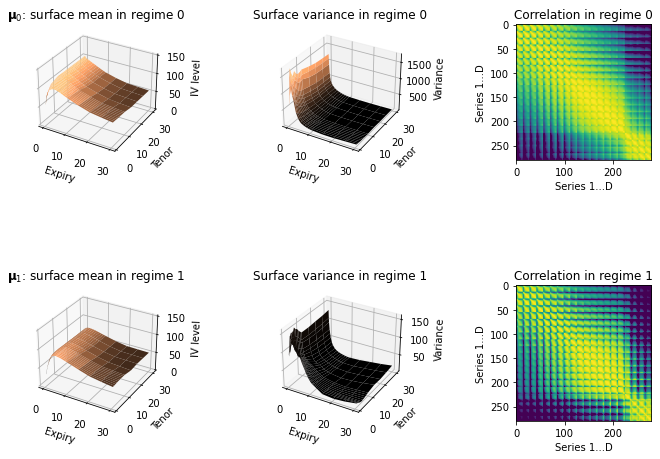

In [355]:
# Means of the regimes
plt.figure(figsize=[10,10])
X, Y = np.meshgrid(expiries, tenors)
ax = plt.subplot(2,3,1,projection='3d')
ax.plot_surface(X,Y,(mppca.mu_[0]+scaler.mean_).reshape(n_exp,n_ten).T,linewidth=1,cmap='copper',vmin=40,vmax=100)
ax.set_xlabel('Expiry')
ax.set_ylabel('Tenor')
ax.set_zlabel('IV level')
ax.set_zlim([0,150])
#ax.set_zlabel('Loadings')    
ax.set_title(r'$\mathbf{\mu}_0$: surface mean in regime 0')
if q==0: annotate_ax(ax, '(a)')
    
ax = plt.subplot(2,3,4,projection='3d')
ax.plot_surface(X,Y,(mppca.mu_[1]+scaler.mean_).reshape(n_exp,n_ten).T,linewidth=1,cmap='copper',vmin=40,vmax=100)
ax.set_xlabel('Expiry')
ax.set_ylabel('Tenor')
ax.set_zlabel('IV level')
ax.set_zlim([0,150])
#ax.set_zlabel('Loadings')    
ax.set_title(r'$\mathbf{\mu}_1$: surface mean in regime 1')
    
# Variance of the regimes
X, Y = np.meshgrid(expiries, tenors)
ax = plt.subplot(2,3,2,projection='3d')
ax.plot_surface(X,Y,np.diag(mppca.cov_[0]).reshape(n_exp,n_ten).T,linewidth=1,cmap='copper',vmin=40,vmax=1500)
ax.set_xlabel('Expiry')
ax.set_ylabel('Tenor')
ax.set_zlabel('Variance')
#ax.set_zlim([0,1500])
#ax.set_zlabel('Loadings')    
ax.set_title(r'Surface variance in regime 0')

ax = plt.subplot(2,3,5,projection='3d')
ax.plot_surface(X,Y,np.diag(mppca.cov_[1]).reshape(n_exp,n_ten).T,linewidth=1,cmap='copper',vmin=40,vmax=1500)
ax.set_xlabel('Expiry')
ax.set_ylabel('Tenor')
ax.set_zlabel('Variance')
#ax.set_zlim([0,1500])
#ax.set_zlabel('Loadings')    
ax.set_title(r'Surface variance in regime 1')

    
# Correlation in the regimes
ax = plt.subplot(2,3,3)
ax.imshow(np.corrcoef(X_tr[mppca.R_[:,0]>0.5,:],rowvar=False),vmin=0,vmax=1)#; plt.colorbar()
#ax.plot_surface(X,Y,np.diag(mppca.cov_[1]).reshape(n_exp,n_ten).T,linewidth=1,cmap='copper',vmin=40,vmax=1500)
ax.set_xlabel('Series 1...D')
ax.set_ylabel('Series 1...D')
#ax.set_zlim([0,1500])
#ax.set_zlabel('Loadings')    
ax.set_title(r'Correlation in regime 0')

ax = plt.subplot(2,3,6)
ax.imshow(np.corrcoef(X_tr[mppca.R_[:,1]>0.5,:],rowvar=False),vmin=0,vmax=1)#; plt.colorbar()
#ax.plot_surface(X,Y,np.diag(mppca.cov_[1]).reshape(n_exp,n_ten).T,linewidth=1,cmap='copper',vmin=40,vmax=1500)
ax.set_xlabel('Series 1...D')
ax.set_ylabel('Series 1...D')
#ax.set_zlim([0,1500])
#ax.set_zlabel('Loadings')    
ax.set_title(r'Correlation in regime 1')


    
plt.subplots_adjust(top=0.85, right=0.99, wspace=0.8, hspace=0.0)
plt.savefig(r'H:\report-img\mppca-mean-var-cor.png', bbox_inches='tight', pad_inches=0)

# Principal components in the different regimes

H:\ucl_project_utilities.py @ 2021-09-19 21:39:53


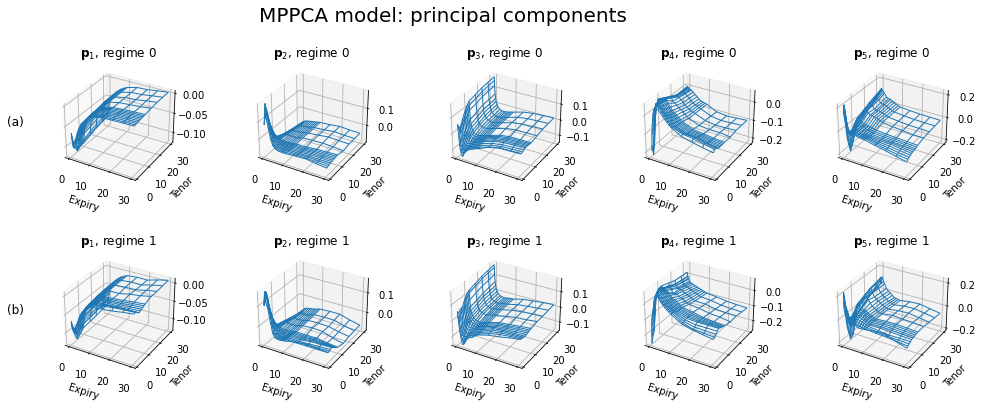

In [356]:
# Putting it all together in one big chart
reload(up)

N_ROWS = 2
fig = plt.figure(figsize = [15,3*N_ROWS])
fig.suptitle('MPPCA model: principal components',fontsize=20)

n_exp = len(expiries)
n_ten = len(tenors)
X, Y = np.meshgrid(expiries, tenors)

ppca = up.PPCA(X_tr,fit=True)
P_surf = ppca.P_surf(n_exp,n_ten)

rf = up.ResidualsFitter(fit_intercept=True)

def annotate_ax(ax, txt):
    ax.annotate(txt, xy=(0, 0.5), xytext=(-40, 0), 
                xycoords='axes fraction', textcoords='offset points', size='large', ha='center', va='baseline')
    

Q = 5
projection = 'pca'
ZQ = ppca.ZQ(Q=Q, normalise=False, projection=projection)
for q in range(Q):
    # Principal components
    ax = plt.subplot(N_ROWS,Q,q+1,projection='3d')
    ax.plot_wireframe(X,Y,mppca.P_[0][:,q].reshape(n_exp,n_ten).T,linewidth=1)
    #ax.plot_surface(X,Y,P_surf[q].T,cmap='cool',vmin=np.min(ppca.P[:,:Q]),vmax=np.max(ppca.P[:,:Q]))
    ax.set_xlabel('Expiry')
    ax.set_ylabel('Tenor')
    #ax.set_zlabel('Loadings')    
    ax.set_title(r'$\mathbf{p}_'+'{}$'.format(q+1)+', regime '+str(0))
    if q==0: annotate_ax(ax, '(a)')
        
    # Principal components
    ax = plt.subplot(N_ROWS,Q,Q+q+1,projection='3d')
    ax.plot_wireframe(X,Y,mppca.P_[1][:,q].reshape(n_exp,n_ten).T,linewidth=1)
    #ax.plot_surface(X,Y,P_surf[q].T,cmap='cool',vmin=np.min(ppca.P[:,:Q]),vmax=np.max(ppca.P[:,:Q]))
    ax.set_xlabel('Expiry')
    ax.set_ylabel('Tenor')
    #ax.set_zlabel('Loadings')    
    ax.set_title(r'$\mathbf{p}_'+'{}$'.format(q+1)+', regime '+str(1))
    if q==0: annotate_ax(ax, '(b)')

plt.subplots_adjust(top=0.85, right=0.99, hspace=0.5)
plt.savefig(r'H:\report-img\mppca-pcs.png', bbox_inches='tight', pad_inches=0)

In [374]:
# Calc empirical transition matrix
idx_mix = mppca.predict(X_tr,output='m')
T = np.zeros((mppca.M,mppca.M)) # transition matrix
idx_t = idx_mix[1:]
idx_t_ = idx_mix[:-1]
for t in range(mppca.M):
    for t_ in range(mppca.M):
        T[t,t_] = np.sum((idx_t==t) & (idx_t_==t_)) / np.sum(idx_t_==t_)





H:\ucl_project_utilities.py @ 2021-09-19 22:18:55


H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')
H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')
H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')
H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')


[1496.887 1520.068] [1.952 1.965]
1492.762007093036 1.9367


H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')
H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')
H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')


[1988.993 1891.668] [2.211 2.167]
1987.3729567961964 2.2108


H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')
H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')
H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')


[3027.693 2778.523] [3.694 3.714]
3011.5207222770805 3.6759


H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')
H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')
H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')


[3186.321 3217.269] [3.792 4.159]
3176.2104123815457 3.7809


H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')
H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')


[3541.18  3285.835] [4.059 4.173]
3520.030281516867 4.0398


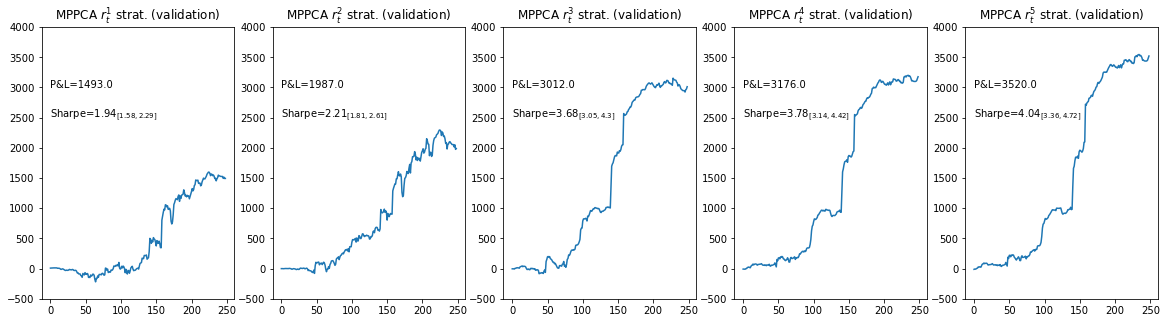

In [541]:
reload(up)
def EdR_VdR(R,rf,prob):
    '''Expected return and variance of R in a mixture setting.'''
    sum_EdR = 0
    sum_EdR2 = 0
    for m in range(len(rf)):
        kappa = 1-rf[m].alpha_
        dev = rf[m].intercept_/kappa - R
        v = rf[m].epsilon_var_        
        sum_EdR += kappa * dev * (prob[m] if (np.ndim(prob)==1) else prob[:,[m]])
        sum_EdR2 += ((kappa * dev)**2 + v) * (prob[m] if (np.ndim(prob)==1) else prob[:,[m]])
    
    return sum_EdR, sum_EdR2 - sum_EdR**2

fig, axes = plt.subplots(nrows=1,ncols=5,figsize=[4*5,5])
# Mixture tracker = residuals for mixture M

for Q in range(1,6):

    # For each mixture component, the PPCA model
    ppca_mix = np.array([up.PPCA(X_tr, mu=mppca.mu_[m], P=mppca.P_[m][:,:Q], 
                                 s2=(mppca.sigma2_[m]*(D-mppca.Q) + mppca.ev_[m][Q:].sum())/(D-Q), 
                                 ev=mppca.ev_[m][:Q], 
                                 fit=False) for m in range(mppca.M)]) 
    resp = mppca.predict(X_tr,output='r') # Responsibility of each mixture

    # and the same on check data (val data or other)
    X_check = X_val
    N_check = X_check.shape[0]
    ppca_mix_check = np.array([up.PPCA(X_check, mu=mppca.mu_[m], P=mppca.P_[m][:,:Q], 
                                 s2=(mppca.sigma2_[m]*(D-mppca.Q) + mppca.ev_[m][Q:].sum())/(D-Q), 
                                 ev=mppca.ev_[m][:Q], 
                                 fit=False) for m in range(mppca.M)])  

    RQ = np.full((mppca.M,N,D),np.nan) # For each mixture tracker, the time series
    RQ_check = np.full((mppca.M,N_check,D),np.nan) # For each mixture tracker, the time series, for val data
    pos = np.full((mppca.M,N_check,D),np.nan)
    pnl = np.full((mppca.M,N_check-1,D),np.nan) # one day less
    EdR = np.full((mppca.M,N_check,D),np.nan)
    VdR = np.full((mppca.M,N_check,D),np.nan)


    # Now for each (t), get the proba to move to each mixture at (t+1)
    idx_mix_check = mppca.predict(X_check,output='m')
    resp_check = mppca.predict(X_check,output='r')
    proba_next = np.zeros((idx_mix_check.size, mppca.M))
    for t, m in enumerate(idx_mix_check):
        proba_next[t] = T[:,m]

    # For each mixture tracker, M resids dynamics in M states to fit:
    rf_tr = np.array([[up.ResidualsFitter(fit_intercept=True) for m in range(mppca.M)] for m in range(mppca.M)]) 

    # What proba to use
    prob = mppca.pi_
    #prob = proba_next
    for m in range(mppca.M):
        # Residuals and fitters for the residuals in this regime
        RQ[m] = ppca_mix[m].RQ(Q=Q,projection='ppca')
        [rf_tr[m,mm].fit(RQ[m], sample_weight=resp[:,mm]) for mm in range(mppca.M)]

        # Ok, so now we have fitted each RQ[m] dynamics in M states
        # And we now use that on validation data
        RQ_check[m] = ppca_mix_check[m].RQ(Q=Q,projection='ppca')
        EdR[m], VdR[m] = EdR_VdR(RQ_check[m],rf_tr[m],prob)
        s0 = 3
        pos[m] = (EdR[m] / np.sqrt(VdR[m]/252) > s0)*1 - (-EdR[m] / np.sqrt(VdR[m]/252) > s0)*1
        pnl[m] = pos[m][:-1] * np.diff(RQ_check[m],axis=0)


    cum_pnl_check = np.array([np.cumsum(pnl[m],axis=0).sum(axis=1) for m in range(mppca.M)]).T
    #axes[Q-1].plot(cum_pnl_check)
    cum_pnl_comb = np.array([pnl[m].sum(axis=1) * resp_check[:-1,m] for m in range(mppca.M)]).T.cumsum(0) # TODO: 1: or :-1 ??
    cum_pnl_comb_sum = cum_pnl_comb.sum(axis=1)
    axes[Q-1].plot(cum_pnl_comb_sum)
    axes[Q-1].set_ylim([-500,4000])
    axes[Q-1].set_title('MPPCA $r_t^{}$ strat. (validation)'.format(Q))
    axes[Q-1].text(0,3000,'P&L='+str(np.round(cum_pnl_comb_sum[-1],0)))
    sr,sr_lo,sr_hi = up.Sharpe(cum_pnl_comb_sum,return_ci=True,round_sr=2)
    axes[Q-1].text(0,2500,'Sharpe='+str(sr)+r'$_{['+str(sr_lo)+','+str(sr_hi)+']}$')

    print(cum_pnl_check[-1], up.Sharpe(cum_pnl_check))
    print(cum_pnl_comb.sum(1)[-1], up.Sharpe(cum_pnl_comb.sum(1)))

# We choose Q=5 which has the best Sharpe and return

## And now check perf on the holdout test set after refitting on train+val

In [459]:
refit = True

if not refit:
    mppca_refit = mppca
    X_tr_val = X_tr
if refit: # REFIT ON TRAIN + VAL
    X1_tr_val = np.vstack([X1_tr,X1_val])
    scaler_tr_val = StandardScaler(with_mean=True, with_std=False)
    X_tr_val = scaler_tr_val.fit_transform(X1_tr_val)

    # Fit the MPPCA using multiple starts
    reload(up)
    N_STARTS = 10
    N_GMM_STARTS = 4
    M = 2 # Mixtures
    Q = 10 # Latent space dimension

    #plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, N_STARTS+3))))

    idx_max = 0
    llh_max = -np.inf
    mppca_refit_list = []
    for s in range(N_STARTS):
        model_refit = up.MPPCA(M=M, Q=Q, initialisation='gmm' if s < N_GMM_STARTS else 'random', max_iter=250, tol=1e-4)
        mppca_refit_list.append(model_refit)
        model_refit.fit(X_tr_val)
        if np.nanmax(model_refit.L_) > llh_max:
            mppca_refit = model_refit
            llh_max = np.nanmax(model_refit.L_)
        llh_list = np.array([m.L_.tolist() for m in mppca_refit_list]).T    

    print(N_STARTS, 'starts completed!')


H:\ucl_project_utilities.py @ 2021-09-19 22:18:55
MPPCA iteration:0 25 
MPPCA iteration:0 
MPPCA iteration:0 25 
MPPCA iteration:0 25 
MPPCA iteration:0 25 50 75 
MPPCA iteration:0 25 50 
MPPCA iteration:0 25 
MPPCA iteration:0 25 
MPPCA iteration:0 25 
MPPCA iteration:0 25 
10 starts completed!


Text(0.5, 0, 'Observation')

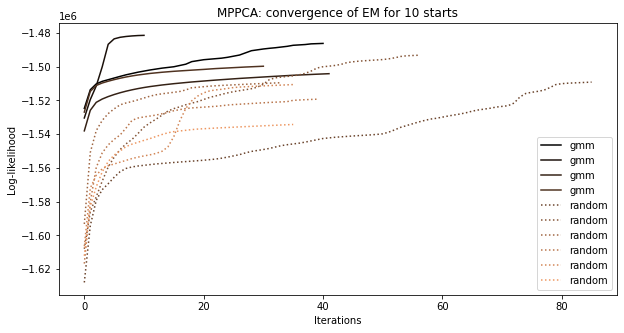

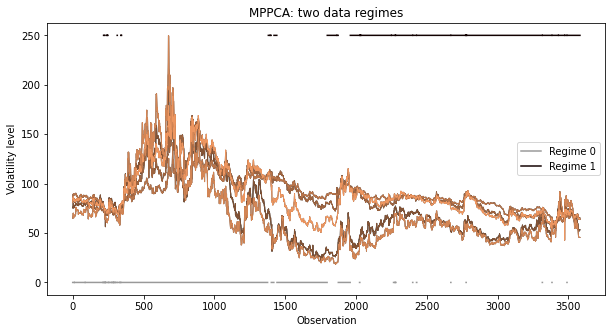

In [461]:
# Convergence of EM
plt.figure(figsize=[10,5])
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, N_STARTS+3))))
[plt.plot(model.L_[2:],'-' if model.initialisation=='gmm' else ':', label=model.initialisation) for model in mppca_refit_list]
plt.legend()
plt.title('MPPCA: convergence of EM for 10 starts')
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')

# Identified periods
plt.figure(figsize=[10,5])
idx_mix = mppca_refit.predict(X_tr_val,output='m')
X1_mix = np.full((mppca_refit.M, X1_tr_val.shape[0], X1_tr_val.shape[1]),np.nan)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, N_STARTS+3))))
for m in range(mppca_refit.M):    
    idx = (idx_mix==m)
    X1_mix[m][idx] = X1_tr_val[idx]
    #plt.plot(X1_mix[m][:,idx_long_series[:5]],'k' if m==0 else 'r', linewidth=1,label='Population'+str(m))
    plt.plot(X1_tr_val[:,idx_long_series[:5]],linewidth=1)


idx_0 = idx_mix * np.nan
idx_0[idx_mix==0] = 0
idx_1 = idx_mix * np.nan
idx_1[idx_mix==1] = 1
plt.plot(idx_0*250,c='#999999',label='Regime 0')
plt.plot(idx_1*250,c='#110000', label='Regime 1')
plt.legend()
plt.title('MPPCA: two data regimes')
plt.ylabel('Volatility level')
plt.xlabel('Observation')



    


H:\ucl_project_utilities.py @ 2021-09-19 22:18:55


H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')
H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')
H:\ucl_project_utilities.py:688: UserWarning: s2 already set, returning set value!
  warnings.warn('s2 already set, returning set value!')


[5815.667 5439.716] [5.286 5.05 ]
5687.0920240140795 5.094


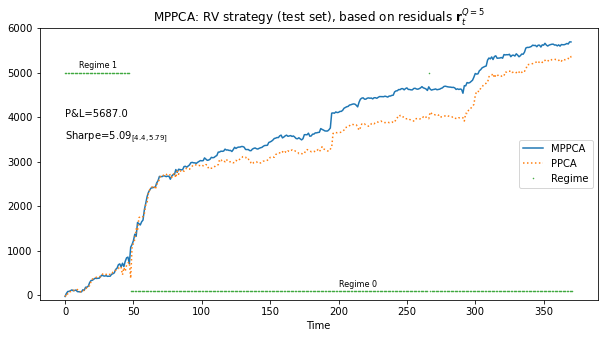

In [542]:
reload(up)
def EdR_VdR(R,rf,prob):
    '''Expected return and variance of R in a mixture setting.'''
    sum_EdR = 0
    sum_EdR2 = 0
    for m in range(len(rf)):
        kappa = 1-rf[m].alpha_
        dev = rf[m].intercept_/kappa - R
        v = rf[m].epsilon_var_        
        sum_EdR += kappa * dev * (prob[m] if (np.ndim(prob)==1) else prob[:,[m]])
        sum_EdR2 += ((kappa * dev)**2 + v) * (prob[m] if (np.ndim(prob)==1) else prob[:,[m]])
    
    return sum_EdR, sum_EdR2 - sum_EdR**2

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=[10,5])
# Mixture tracker = residuals for mixture M

Q = 5

# For each mixture component, the PPCA model
ppca_refit_mix = np.array([up.PPCA(X_tr_val, mu=mppca_refit.mu_[m], P=mppca_refit.P_[m][:,:Q], 
                             s2=(mppca_refit.sigma2_[m]*(D-mppca_refit.Q) + mppca_refit.ev_[m][Q:].sum())/(D-Q), 
                             ev=mppca_refit.ev_[m][:Q], 
                             fit=False) for m in range(mppca_refit.M)]) 
resp = mppca_refit.predict(X_tr_val,output='r') # Responsibility of each mixture

# and the same on check data (val data or other)
X_check = X_te
N_check = X_check.shape[0]
ppca_mix_check = np.array([up.PPCA(X_check, mu=mppca_refit.mu_[m], P=mppca_refit.P_[m][:,:Q], 
                             s2=(mppca_refit.sigma2_[m]*(D-mppca_refit.Q) + mppca_refit.ev_[m][Q:].sum())/(D-Q), 
                             ev=mppca_refit.ev_[m][:Q], 
                             fit=False) for m in range(mppca_refit.M)])  

N_tr_val = X_tr_val.shape[0]
RQ = np.full((mppca_refit.M,N_tr_val,D),np.nan) # For each mixture tracker, the time series
RQ_check = np.full((mppca_refit.M,N_check,D),np.nan) # For each mixture tracker, the time series, for val data
pos = np.full((mppca_refit.M,N_check,D),np.nan)
pnl = np.full((mppca_refit.M,N_check-1,D),np.nan) # one day less
EdR = np.full((mppca_refit.M,N_check,D),np.nan)
VdR = np.full((mppca_refit.M,N_check,D),np.nan)


# Now for each (t), get the proba to move to each mixture at (t+1)
idx_mix_check = mppca_refit.predict(X_check,output='m')
resp_check = mppca_refit.predict(X_check,output='r')
proba_next = np.zeros((idx_mix_check.size, mppca_refit.M))
for t, m in enumerate(idx_mix_check):
    proba_next[t] = T[:,m]

# For each mixture tracker, M resids dynamics in M states to fit:
rf_tr = np.array([[up.ResidualsFitter(fit_intercept=True) for m in range(mppca_refit.M)] for m in range(mppca_refit.M)]) 

# What proba to use
prob = mppca_refit.pi_
#prob = proba_next
for m in range(mppca_refit.M):
    # Residuals and fitters for the residuals in this regime
    RQ[m] = ppca_refit_mix[m].RQ(Q=Q,projection='ppca')
    [rf_tr[m,mm].fit(RQ[m], sample_weight=resp[:,mm]) for mm in range(mppca_refit.M)]

    # Ok, so now we have fitted each RQ[m] dynamics in M states
    # And we now use that on validation data
    RQ_check[m] = ppca_mix_check[m].RQ(Q=Q,projection='ppca')
    EdR[m], VdR[m] = EdR_VdR(RQ_check[m],rf_tr[m],prob)
    s0 = 3
    pos[m] = (EdR[m] / np.sqrt(VdR[m]/252) > s0)*1 - (-EdR[m] / np.sqrt(VdR[m]/252) > s0)*1
    pnl[m] = pos[m][:-1] * np.diff(RQ_check[m],axis=0)


cum_pnl_check = np.array([np.cumsum(pnl[m],axis=0).sum(axis=1) for m in range(mppca.M)]).T
#axes[Q-1].plot(cum_pnl_check)
cum_pnl_comb = np.array([pnl[m].sum(axis=1) * resp_check[:-1,m] for m in range(mppca.M)]).T.cumsum(0) # TODO: 1: or :-1 ??
cum_pnl_comb_sum = cum_pnl_comb.sum(axis=1)
axes.plot(cum_pnl_comb_sum, label='MPPCA')
axes.plot(cum_pnl_te,':',label='PPCA')
axes.plot(resp_check[:,1]*4900+100,'.', markersize=1,label='Regime')
axes.set_ylim([-100,6000])
axes.set_title('MPPCA: RV strategy (test set), based on residuals $\mathbf{r}_t^{Q=5}$')
axes.text(0,4000,'P&L='+str(np.round(cum_pnl_comb_sum[-1],0)))
sr,sr_lo,sr_hi = up.Sharpe(cum_pnl_comb_sum,return_ci=True,round_sr=2)
axes.text(0,3500,'Sharpe='+str(sr)+r'$_{['+str(sr_lo)+','+str(sr_hi)+']}$')
axes.legend()
axes.set_xlabel('Time')

axes.text(10,5100,'Regime 1',fontsize=8)
axes.text(200,200,'Regime 0',fontsize=8)

print(cum_pnl_check[-1], up.Sharpe(cum_pnl_check))
print(cum_pnl_comb.sum(1)[-1], up.Sharpe(cum_pnl_comb.sum(1)))

Text(0.5, 0, 'Observation')

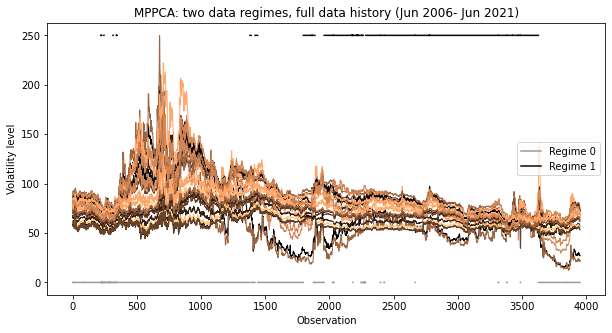

In [507]:
# plt.figure(figsize=[10,5])
# plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, 10))))

X1_tr_val_te = np.vstack([X1_tr,X1_val,X1_te])
X_tr_val_te = scaler.fit_transform(X1_tr_val_te)
resp_ref = mppca_refit.predict(X_tr_val_te,output='m')
# plt.plot(X1_tr_val[:,idx_long_series[:5]],linewidth=1)
# plt.plot(resp_ref*250,'.')

# Identified periods
plt.figure(figsize=[10,5])
idx_mix = mppca_refit.predict(X_tr_val_te,output='m')
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, 7))))
plt.plot(X1_tr_val_te[:,idx_long_series[:20]],linewidth=1)


idx_0 = idx_mix * np.nan
idx_0[idx_mix==0] = 0
idx_1 = idx_mix * np.nan
idx_1[idx_mix==1] = 1
plt.plot(idx_0*250,c='#999999',label='Regime 0')
plt.plot(idx_1*250,c='#110000', label='Regime 1')
plt.legend()
plt.title('MPPCA: two data regimes, full data history (Jun 2006- Jun 2021)')
plt.ylabel('Volatility level')
plt.xlabel('Observation')
